In [ ]:
import rioxarray as rxr
import xarray as xr

In [5]:
from odc.stac import load
import planetary_computer
import pystac_client
import matplotlib.pyplot as plt
import numpy as np
from odc.stac import load
import pystac_client
import matplotlib.pyplot as plt


In [20]:
import pandas as pd
target_raw = pd.read_csv('France_lab.csv')
target_raw.head()

,Unnamed: 0,SAMPLE_ID,CLAY,SILT,SAND,SOC,CaCO3,N,P,K,CEC,GPS_PROJ,GPS_LAT,GPS_LONG,LC1,LC2,LU1,LU2,MINERAL,COUNTRY
0,1,10000,40.0,52.0,8.0,15.6,1,1.4,42.6,491.1,24.6,WGS84,45.893933,4.680379,B82,E10,U111,8,mineral,FRANCE
1,2,10001,26.0,18.0,56.0,19.8,1,1.6,19.5,279.1,20.6,WGS84,45.816720,4.584692,E10,8,U370,8,mineral,FRANCE
2,3,10002,22.0,41.0,37.0,33.5,1,2.6,37.8,399.1,15.0,WGS84,45.983716,4.671533,E10,8,U111,8,mineral,FRANCE
3,4,10004,27.0,47.0,26.0,66.1,21,6.6,147.7,1080.6,30.5,WGS84,45.908022,4.601575,E10,8,U111,8,mineral,FRANCE
4,5,10005,16.0,32.0,52.0,38.1,0,2.6,49.6,293.9,7.8,WGS84,46.082345,4.480490,E20,8,U111,8,mineral,FRANCE


In [27]:
long_lat = target_raw[['GPS_LONG','GPS_LAT']]
print(long_lat.iloc[0])

GPS_LONG     4.680379
GPS_LAT     45.893933
Name: 0, dtype: float64


In [52]:
def create_bbox(long_lat,index=0, step=0.000001):
    # Create bounding box
    bbox = [
        long_lat.iloc[index]['GPS_LONG'] - step,
        long_lat.iloc[index]['GPS_LAT'] - step,
        long_lat.iloc[index]['GPS_LONG'] + step,
        long_lat.iloc[index]['GPS_LAT'] + step
    ]
    
    return bbox

In [ ]:
def get_stac_data(catalog, collection, measurements,
                  long_lat, index, bbox_step=0.000001):


    bbox = create_bbox(long_lat, index, bbox_step)

    # Search for items
    search = catalog.search(
        collections=collection,
        bbox=bbox,
        datetime="2018-03-01/2020-12-31"
    )

    # Convert search results to list
    items = list(search.items())

    if len(items) > 0:
        # Load just the MREF layer
        dataset = load(
            items,
            measurements=measurements,  # Surface Statistics
            bbox=bbox,
            resolution=20  # Sentinel-2 resolution in meters
        )
        return dataset.isel(time=0)
        
    else:
        print("No items found for the specified area and time range")

In [ ]:
# Initialize STAC catalog
dlr_catalog = pystac_client.Client.open("https://geoservice.dlr.de/eoc/ogc/stac/v1")
dlr_measurements = ["MREF_B02", "MREF_B03", "MREF_B04", "MREF_B05", "MREF_B06", "MREF_B07", "MREF_B08", "MREF_B8A", "MREF_B11", "MREF_B12",  # Mean Reflectance bands
                        "MREF-STD_B02", "MREF-STD_B03", "MREF-STD_B04", "MREF-STD_B05", "MREF-STD_B06", "MREF-STD_B07", "MREF-STD_B08", "MREF-STD_B8A", "MREF-STD_B11", "MREF-STD_B12",  # Standard deviation bands
                        "SRC_B02", "SRC_B03", "SRC_B04", "SRC_B05", "SRC_B06", "SRC_B07", "SRC_B08", "SRC_B8A", "SRC_B11", "SRC_B12",  # Bare Surface Reflectance bands
                        "SRC-STD_B02", "SRC-STD_B03", "SRC-STD_B04", "SRC-STD_B05", "SRC-STD_B06", "SRC-STD_B07", "SRC-STD_B08", "SRC-STD_B8A", "SRC-STD_B11", "SRC-STD_B12",  # Bare Surface Standard Deviation bands
                        "SRC-CI95_B02", "SRC-CI95_B03", "SRC-CI95_B04", "SRC-CI95_B05", "SRC-CI95_B06", "SRC-CI95_B07", "SRC-CI95_B08", "SRC-CI95_B8A", "SRC-CI95_B11", "SRC-CI95_B12",  # Bare Surface 95% Confidence Interval bands
                        "SFREQ-BSF" #, "SFREQ-BSC", "SFREQ-VPC"
                        ]
dlr_collection=["S2-soilsuite-europe-2018-2022-P5Y"]

In [80]:
# Define your area of interest (coordinates in WGS84)

point = search_catalog(catalog, long_lat, 
                       index = 10)
print(long_lat.iloc[10])
p_df = point.to_dataframe()
p_df = p_df.reset_index()
p_df

GPS_LONG     5.964908
GPS_LAT     47.338798
Name: 10, dtype: float64


,y,x,spatial_ref,time,MREF_B02,MREF_B03,MREF_B04,MREF_B05,MREF_B06,MREF_B07,...,SRC-CI95_B03,SRC-CI95_B04,SRC-CI95_B05,SRC-CI95_B06,SRC-CI95_B07,SRC-CI95_B08,SRC-CI95_B8A,SRC-CI95_B11,SRC-CI95_B12,SFREQ-BSF
0,2699990.0,4015990.0,3035,2018-03-01,522,814,969,1310,2182,2568,...,61,84,87,98,107,111,118,139,106,0.127962


In [81]:
import geopandas as gpd
from shapely.geometry import Point

# Create geometry column from x and y coordinates
geometry = [Point(x, y) for x, y in zip(p_df['x'], p_df['y'])]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(p_df, geometry=geometry, crs=3035)  # EPSG:3035 is your spatial reference

# If you want to drop the original x,y columns (optional)
gdf = gdf.drop(['x', 'y'], axis=1)
gdf

,spatial_ref,time,MREF_B02,MREF_B03,MREF_B04,MREF_B05,MREF_B06,MREF_B07,MREF_B08,MREF_B8A,...,SRC-CI95_B04,SRC-CI95_B05,SRC-CI95_B06,SRC-CI95_B07,SRC-CI95_B08,SRC-CI95_B8A,SRC-CI95_B11,SRC-CI95_B12,SFREQ-BSF,geometry
0,3035,2018-03-01,522,814,969,1310,2182,2568,2703,2880,...,84,87,98,107,111,118,139,106,0.127962,POINT (4015990.000 2699990.000)


In [84]:
gdf.to_parquet('point.parquet')

In [82]:
# dataset
# r = dataset.MREF_B04
# g = dataset.MREF_B03
# b = dataset.MREF_B02

# bands = [r, g, b]

# rgb = xr.concat(bands, dim="band").transpose("y", "x", "band")
# rgb

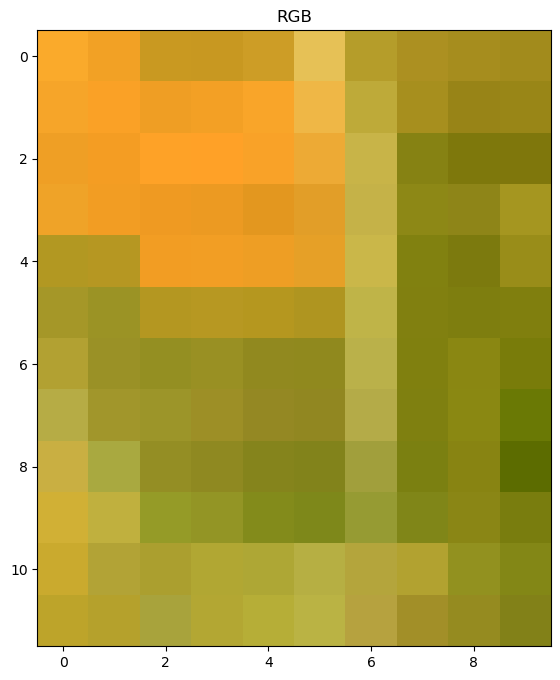

In [ ]:
# # Normalize the data to 0-1 range
# rgb_normalized = (rgb - rgb.min()) / (rgb.max() - rgb.min())

# plt.figure(figsize=(10, 8))
# plt.imshow(rgb_normalized)
# plt.title('RGB')
# plt.show()

In [94]:
import planetary_computer as pc

In [102]:
from pystac_client import Client
import numpy as np
import pandas as pd
from odc.stac import load
import planetary_computer as pc

# Function to create bounding box around a point
def create_bbox(long_lat, index, bbox_step=0.000001):
    lon = long_lat.iloc[index]['GPS_LONG']
    lat = long_lat.iloc[index]['GPS_LAT']
    
    return [
        lon - bbox_step,  # minx
        lat - bbox_step,  # miny
        lon + bbox_step,  # maxx
        lat + bbox_step   # maxy
    ]

# Base function to get STAC data
def get_stac_data(catalog, collection, measurements,
                  long_lat, index, bbox_step=0.000001,
                  datetime=None, resolution=None):
    bbox = create_bbox(long_lat, index, bbox_step)

    # Build search parameters
    search_params = {
        'collections': collection,
        'bbox': bbox
    }
    
    # Add datetime if specified
    if datetime:
        search_params['datetime'] = datetime

    try:
        # Search for items
        search = catalog.search(**search_params)
        items = list(search.items())

        if len(items) > 0:
            # Sign the items for Planetary Computer
            items = [pc.sign(item) for item in items]
            
            # Build load parameters
            load_params = {
                'measurements': measurements,
                'bbox': bbox
            }
            
            # Add resolution if specified
            if resolution:
                load_params['resolution'] = resolution
                
            dataset = load(items, **load_params)
            return dataset.isel(time=0) if 'time' in dataset.dims else dataset
        else:
            print(f"No items found for collection {collection} at index {index}")
            return None
            
    except Exception as e:
        print(f"Error processing index {index}: {str(e)}")
        return None

# Initialize STAC catalogs
pc_catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace
)

io_earth = Client.open(
    "https://earth-search.aws.element84.com/v0"
)

# Functions for specific datasets
def get_nasadem_data(long_lat, index):
    try:
        return get_stac_data(
            catalog=pc_catalog,
            collection='nasadem',
            measurements=['elevation'],
            long_lat=long_lat,
            index=index,
            resolution=30
        )
    except Exception as e:
        print(f"Error getting NASADEM data for index {index}: {str(e)}")
        return None

def get_landcover_data(long_lat, index):
    try:
        return get_stac_data(
            catalog=pc_catalog,
            collection='esa-cci-lc',
            measurements=['lccs_class', 'change_count', 'observation_count'],
            long_lat=long_lat,
            index=index,
            datetime="2009",
            resolution=300
        )
    except Exception as e:
        print(f"Error getting land cover data for index {index}: {str(e)}")
        return None

def get_worldclim_data(long_lat, index):
    try:
        return get_stac_data(
            catalog=pc_catalog,
            collection='worldclim-v2',
            measurements=[
                'tavg',      # Average temperature
                'prec',      # Precipitation
                'srad',      # Solar radiation
                'wind',      # Wind speed
                'vapr'       # Water vapor pressure
            ],
            long_lat=long_lat,
            index=index,
            datetime="2009",
            resolution=1000  # WorldClim resolution
        )
    except Exception as e:
        print(f"Error getting WorldClim data for index {index}: {str(e)}")
        return None

# Function to extract all auxiliary data for one point
def get_auxiliary_data(long_lat, index):
    aux_data = {}
    
    try:
        # Get NASADEM data
        nasadem = get_nasadem_data(long_lat, index)
        if nasadem is not None:
            aux_data['elevation'] = float(nasadem.elevation.values)
        
        # Get Land Cover data
        landcover = get_landcover_data(long_lat, index)
        if landcover is not None:
            aux_data['lccs_class'] = int(landcover.lccs_class.values)
            aux_data['change_count'] = int(landcover.change_count.values)
            aux_data['observation_count'] = int(landcover.observation_count.values)
            
        # Get WorldClim data
        worldclim = get_worldclim_data(long_lat, index)
        if worldclim is not None:
            aux_data['temperature'] = float(worldclim.tavg.values)
            aux_data['precipitation'] = float(worldclim.prec.values)
            aux_data['solar_radiation'] = float(worldclim.srad.values)
            aux_data['wind_speed'] = float(worldclim.wind.values)
            aux_data['vapor_pressure'] = float(worldclim.vapr.values)
            
    except Exception as e:
        print(f"Error processing auxiliary data for index {index}: {str(e)}")
    
    return aux_data

# Extract auxiliary data for all points
def get_all_auxiliary_data(long_lat):
    all_data = []
    
    for i in range(len(long_lat)):
        data = get_auxiliary_data(long_lat, i)
        all_data.append(data)
        
        if i % 100 == 0:
            print(f"Processed {i} points")
    
    return pd.DataFrame(all_data)

c:\Users\luis_\miniconda3\envs\geo_311\Lib\site-packages\pystac_client\client.py:190: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


In [103]:
get_worldclim_data(long_lat, 10)


No items found for collection worldclim-v2 at index 10


In [100]:
get_auxiliary_data(long_lat, 100)

C:\Users\luis_\AppData\Local\Temp\ipykernel_25192\229099859.py:133: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux_data['elevation'] = float(nasadem.elevation.values)
C:\Users\luis_\AppData\Local\Temp\ipykernel_25192\229099859.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux_data['lccs_class'] = int(landcover.lccs_class.values)
C:\Users\luis_\AppData\Local\Temp\ipykernel_25192\229099859.py:139: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aux_data['cha

No items found for collection worldclim-v2 at index 100


{'elevation': nan, 'lccs_class': 0, 'change_count': 0, 'observation_count': 0}

In [ ]:
# Extract auxiliary data for all points

# Extract auxiliary data for all points
def get_all_auxiliary_data(long_lat):
    all_data = []
    
    for i in range(len(long_lat)):
        data = get_auxiliary_data(long_lat, i)
        all_data.append(data)
        
        if i % 100 == 0:
            print(f"Processed {i} points")
    
    return pd.DataFrame(all_data)

# Get coordinates from your LUCAS data
lat_lon = target_raw[['GPS_LAT', 'GPS_LONG']]

# Get auxiliary data for all points
auxiliary_data = get_all_auxiliary_data(lat_lon)

# Save the data
auxiliary_data.to_csv('auxiliary_data.csv', index=False)